# Descriptive Statistics for Time-Series Data
Time-series data is a sequence of data points indexed in time order. Unlike standard cross-sectional data, time-series data has a **temporal dependency**, meaning observations close in time are often related.

This notebook covers the essential descriptive tools for understanding the behavior, trends, and patterns in time-dependent datasets.



In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Apple Stock data (last 2 years)
ticker = "AAPL"
df_ts = yf.download(ticker, start="2021-12-15", end="2024-01-01", auto_adjust=True)
if isinstance(df_ts.columns, pd.MultiIndex):
    df_ts.columns = df_ts.columns.get_level_values(0)
monthly_ts = df_ts['Close'].resample('ME').mean()

print(f"Dataset Loaded: {len(df_ts)} days of {ticker} stock prices.")
print(f"monthly_df: {len(monthly_ts)} months of {ticker} stock prices.")
display(df_ts.head())

[*********************100%***********************]  1 of 1 completed

Dataset Loaded: 513 days of AAPL stock prices.
monthly_df: 25 months of AAPL stock prices.


Price,Close,High,Low,Open,Volume
Date,,,,,
2021-12-15,175.451874,175.647578,168.611887,171.351797,131063300
2021-12-16,168.562943,177.252364,167.085356,175.432283,150185800
2021-12-17,167.466980,169.746975,166.048103,166.282943,195432700
2021-12-20,166.106812,166.919000,163.865966,164.668360,107499100
2021-12-21,169.277267,169.482752,165.490316,167.877951,91185900


In [2]:
fig = go.Figure()

# Daily Trace
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['Close'], name='Daily Close', opacity=0.4))

# Monthly Trace
fig.add_trace(go.Scatter(x=monthly_ts.index, y=monthly_ts.values, 
                         name='Monthly Average', line=dict(width=4, color='orange')))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all", label="All")
        ])
    )
)

fig.update_layout(
    title=f"{ticker} Stock: Interactive Analysis",
    xaxis_title="Date",
    yaxis_title="Price ($)",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

In [4]:
# 1. Ensure columns are flat (Fixes yfinance Multi-Index issue)
if isinstance(df_ts.columns, pd.MultiIndex):
    df_ts.columns = df_ts.columns.get_level_values(0)

# 2. Compute Rolling Statistics
df_ts['MA50'] = df_ts['Close'].rolling(window=50).mean()
df_ts['MA200'] = df_ts['Close'].rolling(window=200).mean()
df_ts['Volatility_20d'] = df_ts['Close'].rolling(window=20).std()

# 3. Create Subplots
fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=True, 
    vertical_spacing=0.1,
    subplot_titles=("Moving Averages (Smoothing)", "Rolling Volatility (20-day Std)")
)

# 4. Add Traces to Top Row (Price & MAs)
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['Close'], name='Actual Price', opacity=0.4), row=1, col=1)
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['MA50'], name='50-day MA', line=dict(color='orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['MA200'], name='200-day MA', line=dict(color='green')), row=1, col=1)

# 5. Add Volatility to Bottom Row
fig.add_trace(go.Scatter(x=df_ts.index, y=df_ts['Volatility_20d'], name='Volatility', line=dict(color='red')), row=2, col=1)

# 6. Layout and Formatting
fig.update_layout(
    height=700, 
    title=f"{ticker} Smoothing and Volatility Analysis",
    template="plotly_white",
    showlegend=True,
    hovermode="x unified"
)

fig.show()

In [5]:
# Perform Additive Decomposition (assuming 252 trading days per year)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# 1. Decomposition (Requires sufficient data points)
decomp = seasonal_decompose(df_ts['Close'], model='additive', period=252)

# 2. Stationarity Check (ADF Test)
result = adfuller(df_ts['Close'])
print(f"ADF p-value: {result[1]:.4f}")

if result[1] > 0.05:
    print("Caution: Data is Non-Stationary. Applying Differencing...")
    df_ts['Returns'] = df_ts['Close'].pct_change().dropna()

ADF p-value: 0.5256
Caution: Data is Non-Stationary. Applying Differencing...


In [6]:
import numpy as np
import plotly.express as px
from statsmodels.tsa.stattools import adfuller

# 1. Stationarity Check Function
def check_stationarity(series, name):
    # Drop NaNs to prevent ADF failure
    clean_series = series.dropna()
    res = adfuller(clean_series)
    
    print(f"--- ADF Test: {name} ---")
    print(f"ADF Statistic: {res[0]:.4f}")
    print(f"p-value:       {res[1]:.4f}")
    
    if res[1] < 0.05:
        print("Result: Stationary (Data is stable, ready for modeling)")
    else:
        print("Result: Non-Stationary (Has trend/variance issues, needs differencing)")

# 2. Check Raw Price (Will likely be Non-Stationary)
# (Assumes df_ts is your stock dataframe from previous steps)
check_stationarity(df_ts['Close'], "Raw Stock Price")

# 3. Apply Log Transformation and Differencing (Log Returns)
# This is the gold standard for research
df_ts['Log_Returns'] = np.log(df_ts['Close'] / df_ts['Close'].shift(1))

# 4. Check Log Returns (Will likely be Stationary)
print("\n")
check_stationarity(df_ts['Log_Returns'], "Log Returns")

# 5. Interactive Visualization
fig = px.line(df_ts, y="Log_Returns", 
              title="Stationary Series: AAPL Log Returns",
              labels={"Log_Returns": "Log Return Value", "Date": "Timeline"})

# Add a horizontal line at 0 for reference
fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.show()

--- ADF Test: Raw Stock Price ---
ADF Statistic: -1.5160
p-value:       0.5256
Result: Non-Stationary (Has trend/variance issues, needs differencing)


--- ADF Test: Log Returns ---
ADF Statistic: -17.0907
p-value:       0.0000
Result: Stationary (Data is stable, ready for modeling)


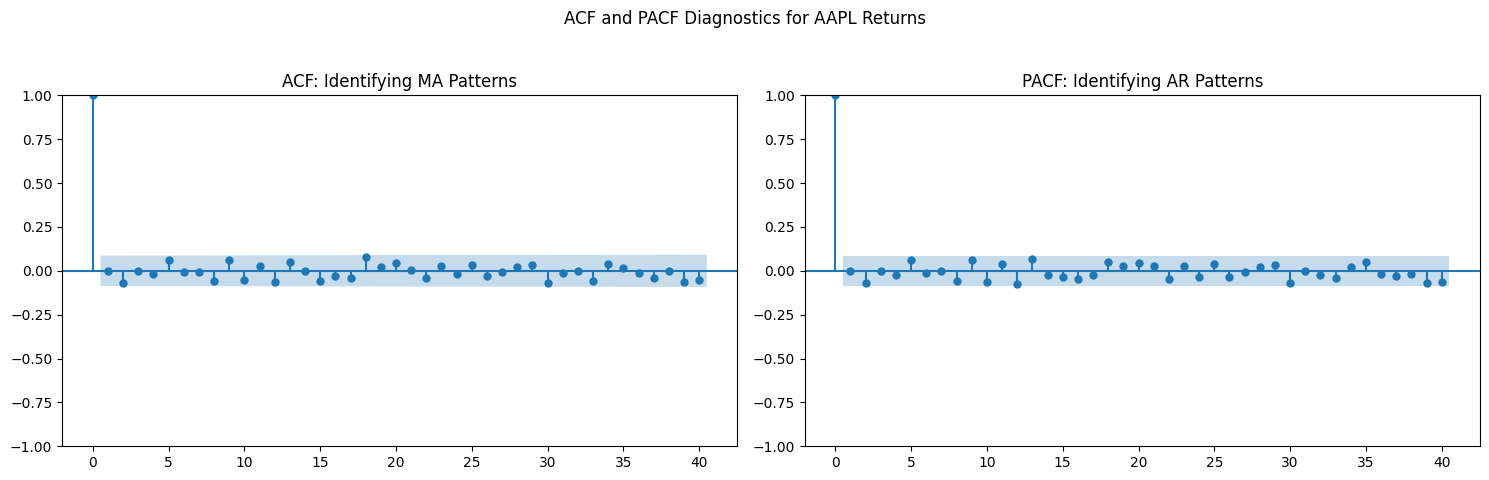

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 1. Setup the figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 2. Plot ACF (Autocorrelation)
# Identifies the Moving Average (MA) order
plot_acf(df_ts['Log_Returns'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF: Identifying MA Patterns")

# 3. Plot PACF (Partial Autocorrelation)
# Identifies the Autoregressive (AR) order
plot_pacf(df_ts['Log_Returns'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF: Identifying AR Patterns")

plt.suptitle("ACF and PACF Diagnostics for AAPL Returns")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()